# Preprocessing

Note that this step is optional. If the data do not yet have one of `X_pca`, `X_emb`, or `state_info`, you will need to run the preprocessing and dimension reduction. 

In [1]:
import cospar as cs

In [2]:
cs.logging.print_version()
cs.settings.verbosity=2 #range: 0 (error),1 (warning),2 (info),3 (hint). 
cs.settings.set_figure_params(format='png',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=3) 

Running cospar 0.1.9 (python 3.8.12) on 2021-12-08 16:34.


In [3]:
# Each dataset should have its folder to avoid conflicts.
cs.settings.data_path='data_cospar' 
cs.settings.figure_path='fig_cospar' 
cs.hf.set_up_folders()

Load an existing dataset. (If you have pre-processed data, you can load it with `cs.hf.read(file_name)`.)

In [4]:
adata_orig=cs.datasets.hematopoiesis_subsampled()

## Dimension reduction

Select highly variable genes. Before this, there is count normalization. It requires that the count matrix is **NOT** log-normalized.

Finding highly variable genes...


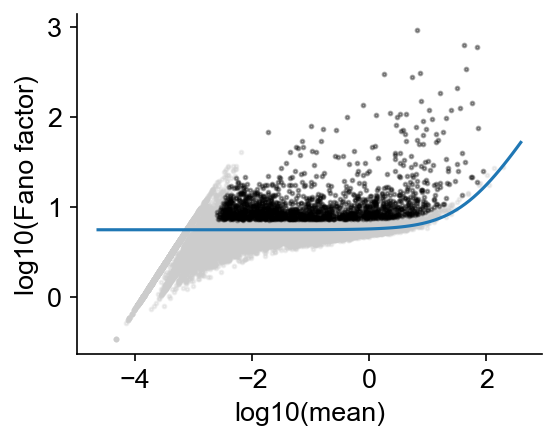

Keeping 1615 genes


In [5]:
cs.pp.get_highly_variable_genes(adata_orig,normalized_counts_per_cell=10000,min_counts=3, 
        min_cells=3, min_gene_vscore_pctl=90)

Compute for each gene its correlation with a set of cell cycle genes. The default cell cycle genes are for mouse.
You need to use your own genes for a different species. This step is optional, but recommended. 

adata.var['highly_variable'] not updated.
Please choose corr_threshold properly, and set confirm_change=True


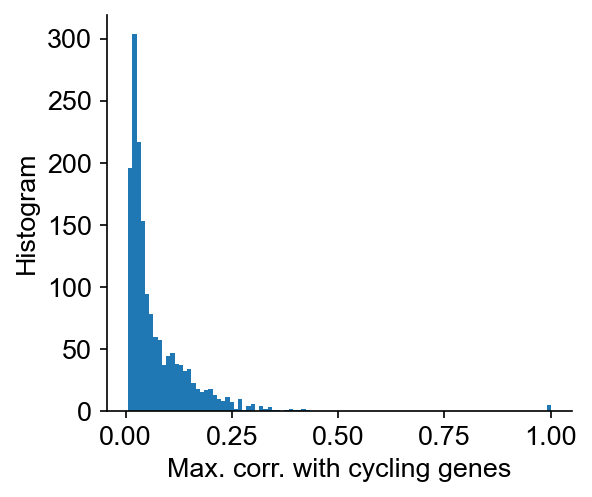

In [6]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig,cycling_gene_list=['Ube2c','Hmgb2', 'Hmgn2', 'Tuba1b', 'Ccnb1', 'Tubb5', 'Top2a','Tubb4b'])

Now, confirm the change at a specific cutoff threshold. 

In [7]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.2,confirm_change=True)

Number of selected non-cycling highly variable genes: 1508
Remove 107 cell cycle correlated genes.
adata.var['highly_variable'] updated


Compute the `X_pca`, `X_emb`. `X_pca` will be used to build the similarity matrix later. `X_emb` is only used for visualization. You can also pass your favorite embedding directly to 
`adata.obsm['X_emb']`.

In [8]:
cs.pp.get_X_pca(adata_orig,n_pca_comp=40) 
cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3) 

/Users/shouwenwang/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/shouwenwang/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Note that previous `X_pca` and `X_emb` (if exists) will be kept and renamed as `X_pca_old` and `X_emb_old`

In [9]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info', 'n_counts'
    var: 'highly_variable', 'highly_variable_old'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'state_info_colors', 'neighbors', 'umap'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_pca_old', 'X_umap', 'X_emb_old'
    obsp: 'distances', 'connectivities'

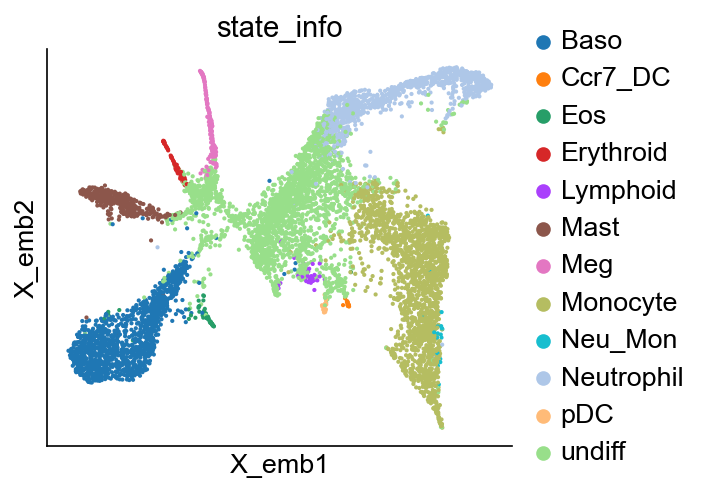

In [10]:
cs.pl.embedding(adata_orig,color='state_info')

## State annotation

This generates `adata_orig.obs['state_info']`. 

In [11]:
cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) 

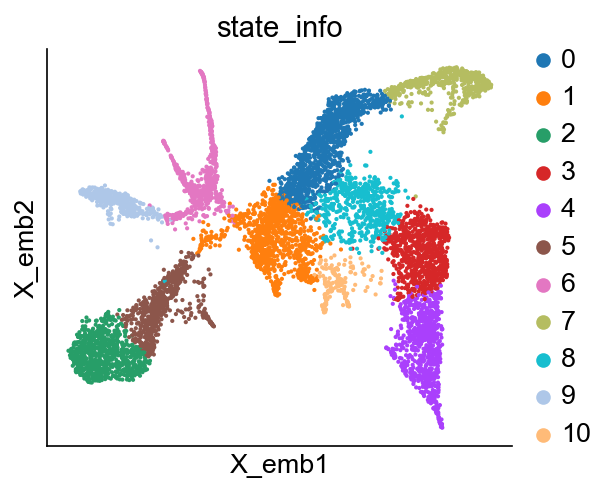

In [12]:
cs.pl.embedding(adata_orig,color='state_info')

Similarly, the pre-existing `state_info` will be renamed

In [13]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info', 'n_counts', 'leiden', 'state_info_old'
    var: 'highly_variable', 'highly_variable_old'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'state_info_colors', 'neighbors', 'umap', 'leiden'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_pca_old', 'X_umap', 'X_emb_old'
    obsp: 'distances', 'connectivities'

### Refine state annotation by marker genes

The goal here is to refine `adata_orig.obs['state_info']`. In this method, a state is selected if it expresses all genes in the list of 
`marker_genes`, and the expression is above the relative threshold `express_threshold`. 
You can also specify which time point you want to focus on. In addition, we also 
include cell states neighboring to these valid states to smooth 
the selection (controlled by `add_neighbor_N`). First, explore parameters to find satisfactory annotation.

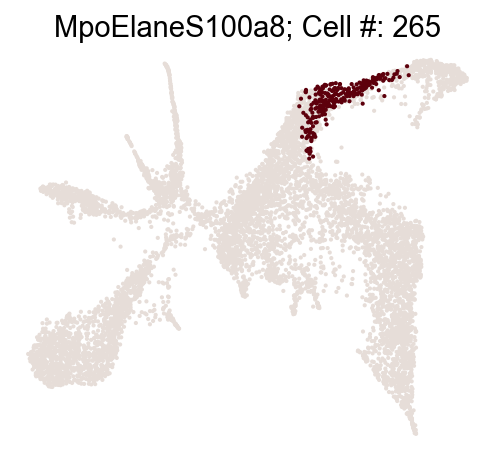

In [14]:
confirm_change=False
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata_orig,marker_genes,express_threshold=0.1,
    selected_times=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

Once you are happy with the result, set `confirm_change=True` to confirm changes to `adata.obs['state_info']`.

Change state annotation at adata.obs['state_info']


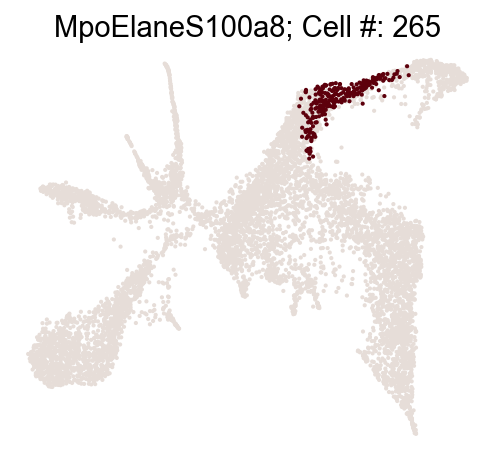

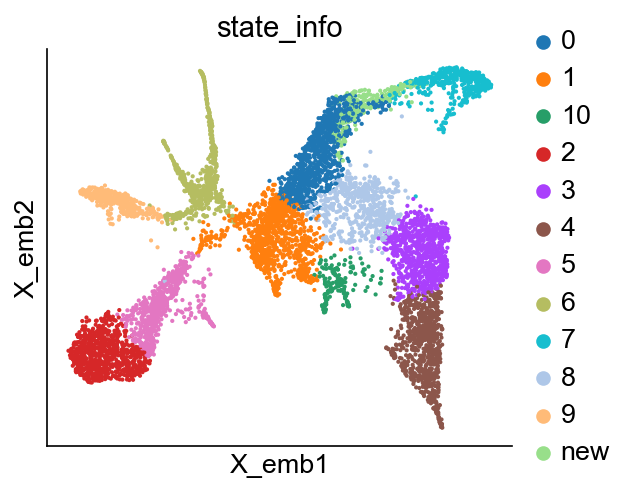

In [15]:
confirm_change=True
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata_orig,marker_genes,express_threshold=0.1,
    selected_times=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

### Refine state annotation by clustering states at given time points

First, explore the parameters.

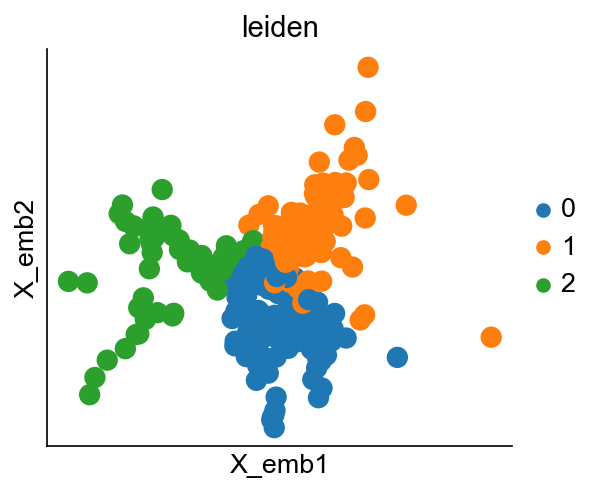

In [16]:
confirm_change=False
cs.pp.refine_state_info_by_leiden_clustering(adata_orig,selected_times=['2'],n_neighbors=20,
            resolution=0.5,confirm_change=confirm_change)

Once you are happy with the result, set `confirm_change=True` to confirm changes to `adata.obs['state_info']`.

## Miscellaneous

In [17]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['7', '0', '6', '8', 'new', '2', '10', '1', '5', '9', '4', '3']
Available time points: ['2' '4' '6']
Clonal time points: ['2' '4' '6']


You can choose to save preprocessed data. It can be loaded using `cs.hf.read(file_name)`. 

In [18]:
# cs.hf.save_preprocessed_adata(adata_orig)